# 🧳 Travel Insurance Prediction — Notebook Overview

This notebook explores which customer characteristics influence the likelihood of purchasing travel insurance and evaluates which classification model performs best for this task. The analysis walks through data preparation, baseline modelling, model comparison, and performance assessment using metrics such as precision, recall, F1 score and ROC curves.


This notebook is intended as an exploratory analysis, highlighting behavioural insights, model strengths and limitations, and recommendations for future data improvements—not as a production-ready solution.

Data Source: https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from ISLP.models import ( ModelSpec as MS, summarize)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('/Users/guywinfield/PycharmProjects/Data/travel_insurance/TravelInsurancePrediction.csv',index_col=0)

In [3]:
df = df_raw.copy()

# Data Preprocessing

A Tour & Travels Company is offering travel insurance package to their customers. Based on the AnnualIncome being denominated in Indian Rupees we'll assume the company is for Indian customers. We'll convert income into USD to make it more relatable, as this data was based in 2019 we'll use a conversion 0.014 rate.

In [4]:
df['AnnualIncomeUSD'] = (df['AnnualIncome'] * 0.014).astype('int32')
df.drop(['AnnualIncome'], axis=1, inplace=True)

In [5]:
df.head()

,Age,Employment Type,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,AnnualIncomeUSD
0,31,Government Sector,Yes,6,1,No,No,0,5600
1,31,Private Sector/Self Employed,Yes,7,0,No,No,0,17500
2,34,Private Sector/Self Employed,Yes,4,1,No,No,1,7000
3,28,Private Sector/Self Employed,Yes,3,1,No,No,0,9800
4,28,Private Sector/Self Employed,Yes,8,1,Yes,No,0,9800


In [6]:
df.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
AnnualIncomeUSD         int32
dtype: object

In [7]:
df.shape

(1987, 9)

In [8]:
cols = list(df.columns)

for col in cols:
    print(df[col].value_counts())

Age
28    506
34    266
31    234
29    192
33    148
26    148
25    146
27    131
32     91
30     65
35     60
Name: count, dtype: int64
Employment Type
Private Sector/Self Employed    1417
Government Sector                570
Name: count, dtype: int64
GraduateOrNot
Yes    1692
No      295
Name: count, dtype: int64
FamilyMembers
4    505
5    426
3    377
6    294
7    178
2     93
8     59
9     55
Name: count, dtype: int64
ChronicDiseases
0    1435
1     552
Name: count, dtype: int64
FrequentFlyer
No     1570
Yes     417
Name: count, dtype: int64
EverTravelledAbroad
No     1607
Yes     380
Name: count, dtype: int64
TravelInsurance
0    1277
1     710
Name: count, dtype: int64
AnnualIncomeUSD
11200    153
7000     143
19600    130
16800    112
15400    107
8400      98
9800      95
18200     91
4200      88
21000     82
14700     82
7700      81
16100     79
12600     72
17500     71
10500     65
5600      65
14000     60
4900      55
11900     55
18900     43
23800     37
20300   

In [9]:
df.isnull().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
AnnualIncomeUSD        0
dtype: int64

In [10]:
print(f"Duplicated Records: {round(df.duplicated().sum()/len(df),3)*100}% \nTotal Record Dupes: {df.duplicated().sum()}\nTotal Record: {len(df)}")

Duplicated Records: 37.1% 
Total Record Dupes: 738
Total Record: 1987


### 🚨 Duplicates 🚨

We've run into our first data quality issue. It looks like we have over a 1/3rd of our records being duplicates. It's difficult to assume these are duplicated records or legitimate instances where we have very similar people but not the same person in our travel insurance data. We might loop back to the original data in our model if we believe it makes a difference.

Let's take a look at some distributions with and without the duplicate records to see if we can spot any differences.

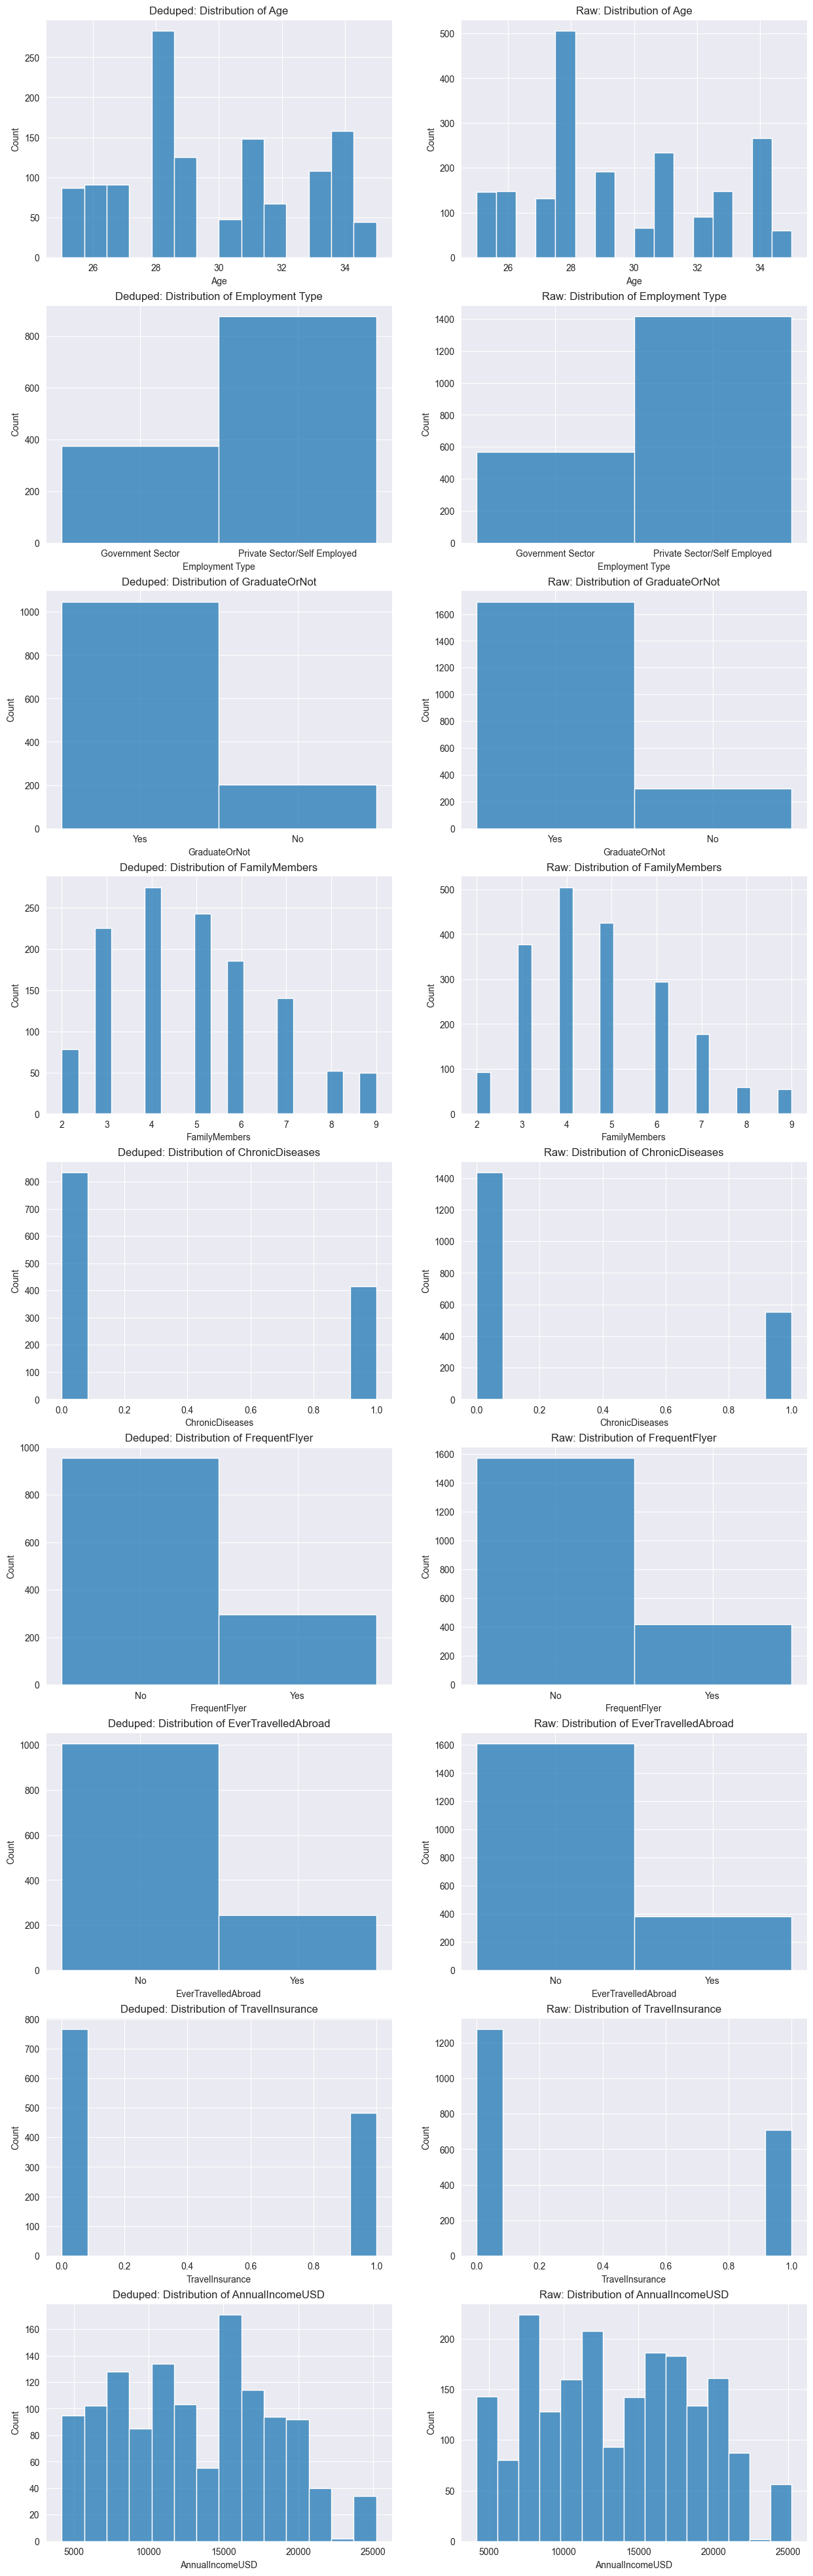

In [11]:
df_deduped = df.drop_duplicates(keep='first')

fig, ax = plt.subplots(9, 2, figsize=(15, 50))

row = 0
for col in cols:
    sns.histplot(x=df_deduped[col], ax=ax[row,0]).set_title('Deduped: Distribution of ' + col)
    sns.histplot(x=df[col], ax=ax[row,1]).set_title('Raw: Distribution of ' + col)
    row += 1


In [12]:
df_deduped.describe()

,Age,FamilyMembers,ChronicDiseases,TravelInsurance,AnnualIncomeUSD
count,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000
mean,29.755805,4.890312,0.333066,0.386709,13083.666934
std,2.921039,1.762313,0.471499,0.487191,5050.209980
min,25.000000,2.000000,0.000000,0.000000,4200.000000
25%,28.000000,4.000000,0.000000,0.000000,8400.000000
50%,29.000000,5.000000,0.000000,0.000000,12600.000000
75%,32.000000,6.000000,1.000000,1.000000,16800.000000
max,35.000000,9.000000,1.000000,1.000000,25200.000000


The distributions seem fairly similar and we aren't seeing any worrying outliers based on charts and describe() function.

However there does appear to be a some key differences in 2 fields:
- AnnualIncomeUSD: Raw data before deduplication seems to be more left skewed. let's see if this changes the median/mean values'
- TravelInsurance: The number of customers with travel insurance policies has a higher ratio when deduplicated

Given that we want to remove noise and ideally have a the highest target variable as possible let's deduplicate our data.

In [13]:
print(f"Raw Travel Insurance Split: {df_raw['TravelInsurance'].value_counts()/len(df_raw)}")
print(f"Deduplicated Travel Insurance Split: {df_deduped['TravelInsurance'].value_counts()/len(df_deduped)}")

Raw Travel Insurance Split: TravelInsurance
0    0.642677
1    0.357323
Name: count, dtype: float64
Deduplicated Travel Insurance Split: TravelInsurance
0    0.613291
1    0.386709
Name: count, dtype: float64


In [14]:
print(f"Deduplicated Income: {round(df_deduped['AnnualIncomeUSD'].mean(),0)}")
print(f"Raw Annual Income: {round(df['AnnualIncomeUSD'].mean(),0)}")

Deduplicated Income: 13084.0
Raw Annual Income: 13059.0


In [15]:
df = df_deduped.copy()

# Feature Engineering

We've already introduced `AnnualIncomeUSD` to make a more relatable datapoint. Let's see what else we can do to expand our options.

One sure place to start is to hot encode some of our categorical features and consider normalising + standardising others.

In [16]:
df.head()

,Age,Employment Type,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,AnnualIncomeUSD
0,31,Government Sector,Yes,6,1,No,No,0,5600
1,31,Private Sector/Self Employed,Yes,7,0,No,No,0,17500
2,34,Private Sector/Self Employed,Yes,4,1,No,No,1,7000
3,28,Private Sector/Self Employed,Yes,3,1,No,No,0,9800
4,28,Private Sector/Self Employed,Yes,8,1,Yes,No,0,9800


In [17]:
df.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
AnnualIncomeUSD         int32
dtype: object

Let's convert our categorical (Or in this case object) fields binary outcomes so that we can expand our features.

In [18]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=df.index)
df_encoded = pd.concat([df, one_hot_df], axis=1)

df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(columns=categorical_columns)

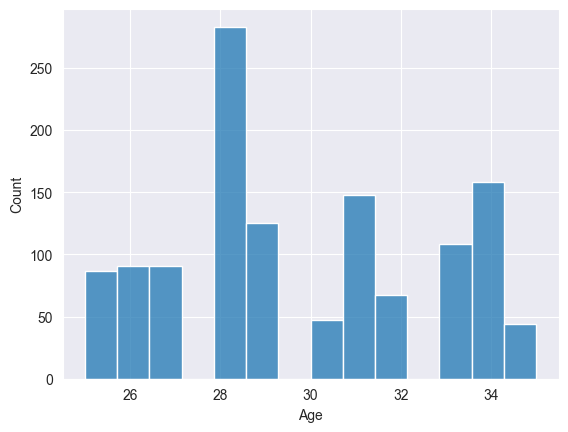

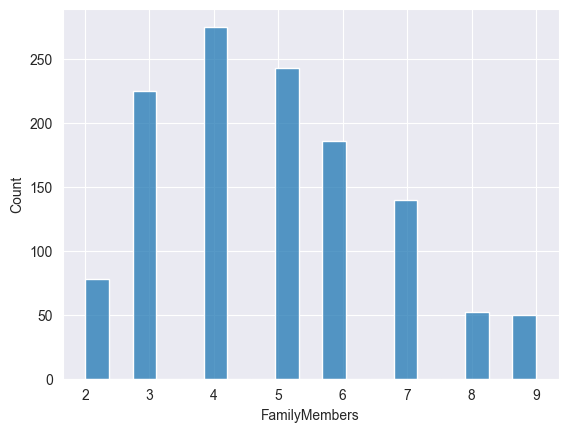

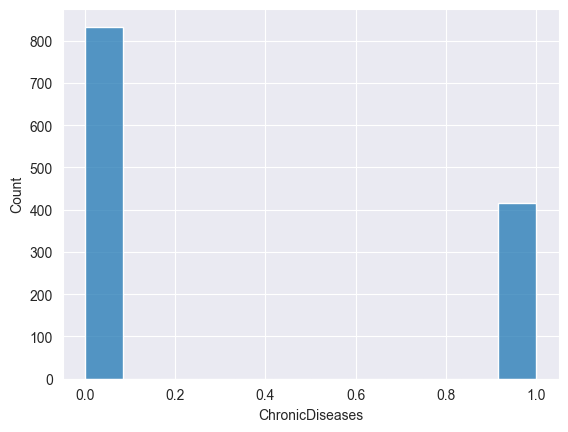

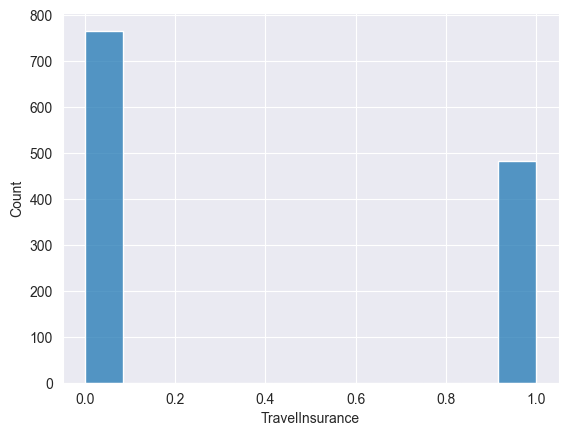

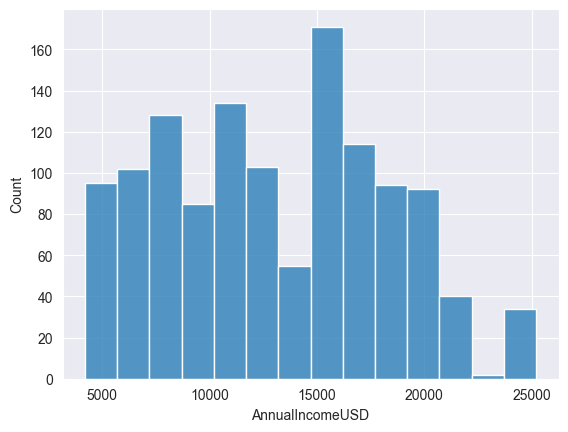

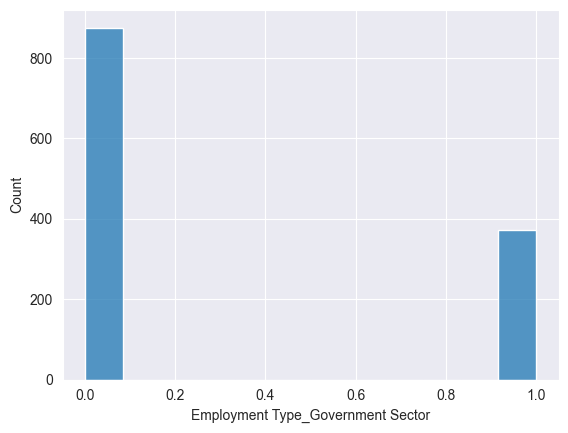

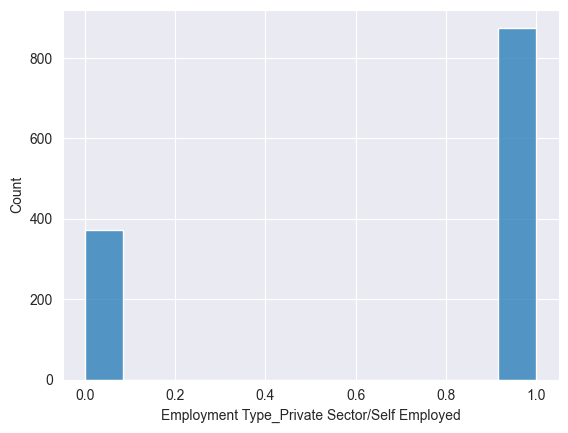

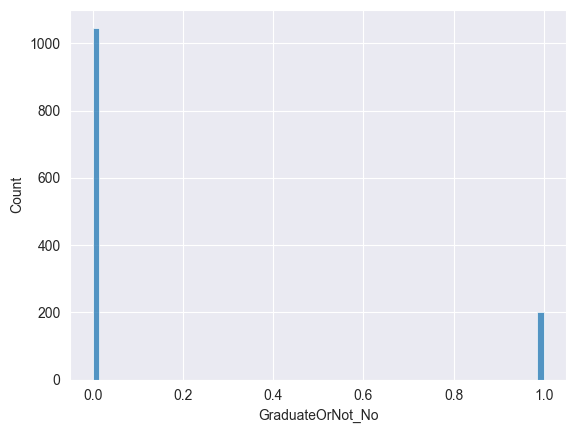

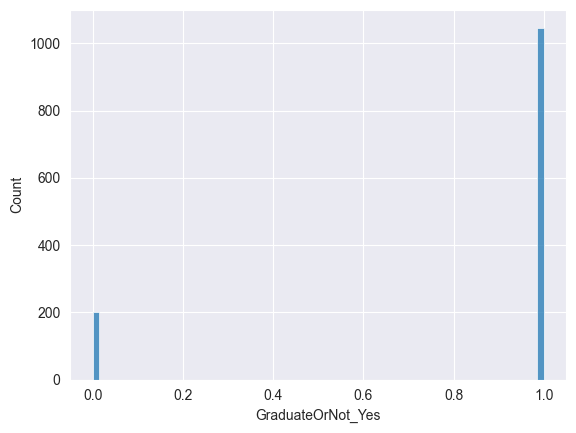

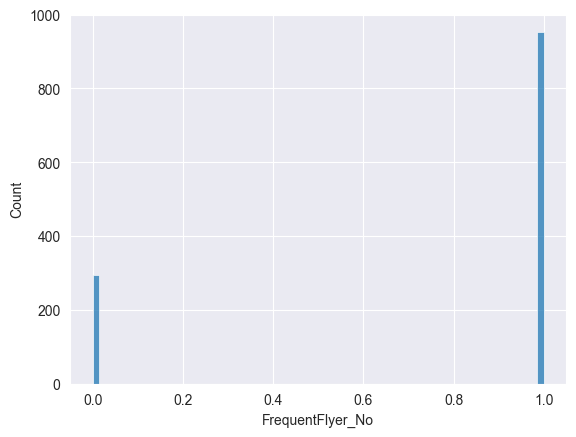

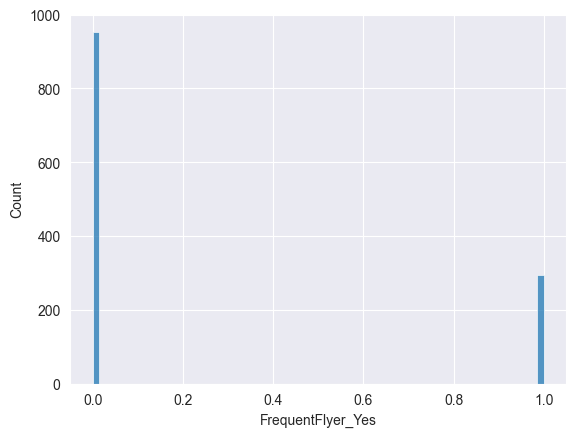

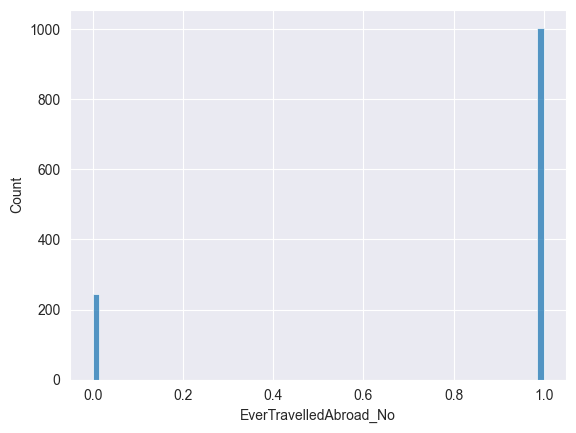

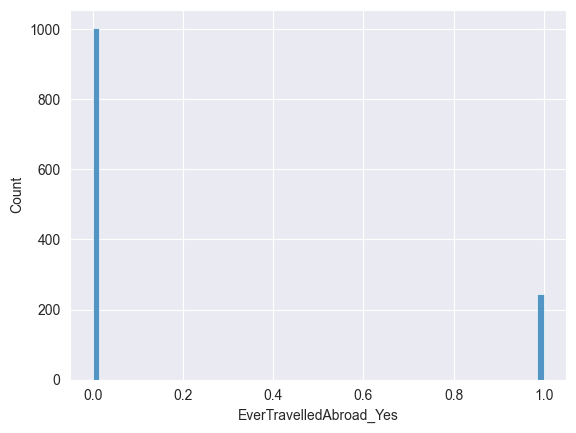

In [19]:
for col in df_encoded.columns:
    sns.histplot(x=df_encoded[col])
    plt.show()

In [20]:
df_encoded.dtypes

Age                                               int64
FamilyMembers                                     int64
ChronicDiseases                                   int64
TravelInsurance                                   int64
AnnualIncomeUSD                                   int32
Employment Type_Government Sector               float64
Employment Type_Private Sector/Self Employed    float64
GraduateOrNot_No                                float64
GraduateOrNot_Yes                               float64
FrequentFlyer_No                                float64
FrequentFlyer_Yes                               float64
EverTravelledAbroad_No                          float64
EverTravelledAbroad_Yes                         float64
dtype: object

We'll normalise with the StandardScaler (Z-score) for models like logistic regression and SVMs.

In [21]:
from sklearn.preprocessing import StandardScaler


cols_to_scale = ['Age', 'FamilyMembers', 'AnnualIncomeUSD']

scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_encoded[cols_to_scale])
df_encoded[cols_to_scale] = scaled_values



In [22]:
df_encoded

,Age,FamilyMembers,ChronicDiseases,TravelInsurance,AnnualIncomeUSD,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,GraduateOrNot_No,GraduateOrNot_Yes,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes
0,0.426113,0.629929,1,0,-1.482446,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.426113,1.197592,0,0,0.874835,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.453557,-0.505398,1,1,-1.205119,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,-0.601330,-1.073061,1,0,-0.650464,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,-0.601330,1.765256,1,0,-0.650464,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,0.768594,0.629929,0,0,-0.095810,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1981,-0.943811,-1.073061,0,1,-0.234474,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1982,1.111076,-0.505398,0,1,1.568153,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1983,-0.601330,0.062266,1,0,2.261472,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


# Exploratory Data Analysis

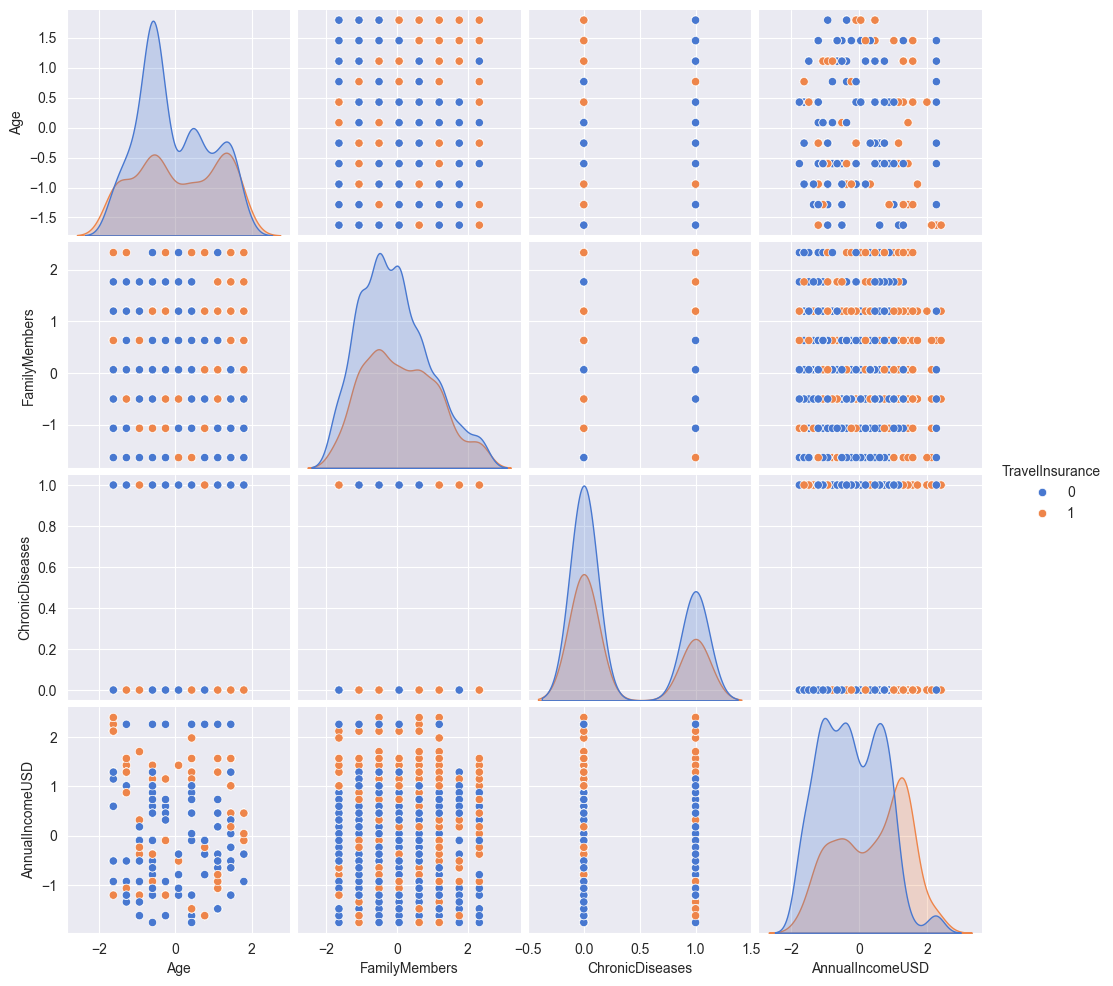

In [23]:
cols = ['Age','FamilyMembers','ChronicDiseases','TravelInsurance','AnnualIncomeUSD']

sns.pairplot(df_encoded[cols], palette='muted',hue='TravelInsurance')

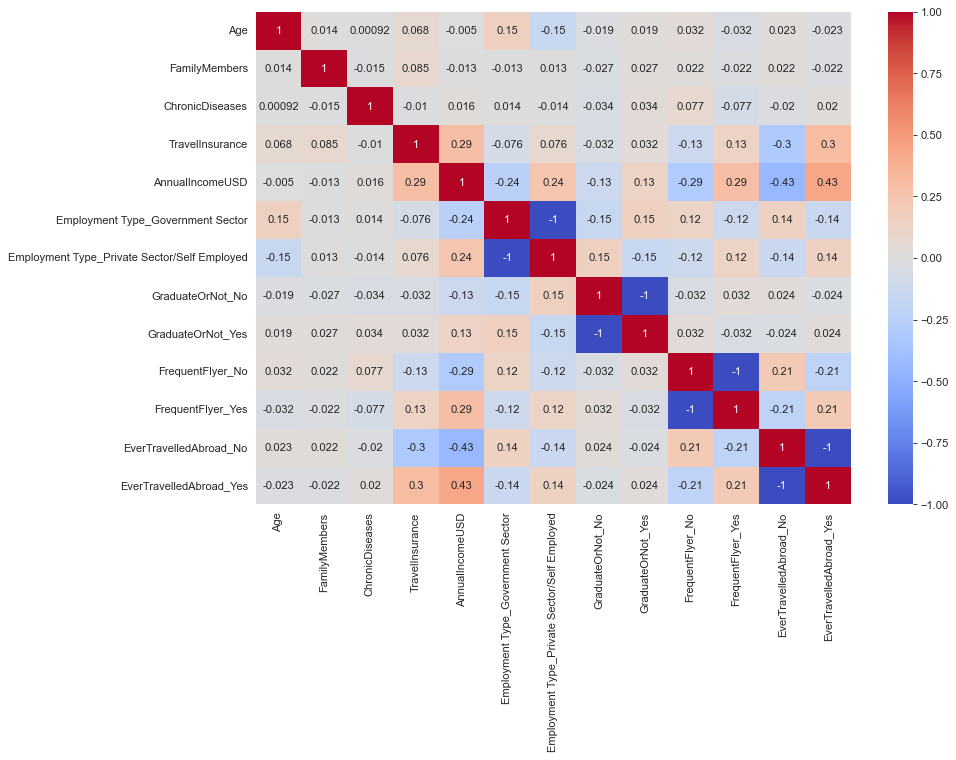

In [24]:
plt.figure(figsize=(12, 8), dpi=80)

sns.heatmap(data=df_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()




In [25]:
df_encoded.corr()['TravelInsurance'].sort_values(ascending=False)


TravelInsurance                                 1.000000
EverTravelledAbroad_Yes                         0.301224
AnnualIncomeUSD                                 0.293913
FrequentFlyer_Yes                               0.127426
FamilyMembers                                   0.084907
Employment Type_Private Sector/Self Employed    0.076309
Age                                             0.067536
GraduateOrNot_Yes                               0.031770
ChronicDiseases                                -0.010015
GraduateOrNot_No                               -0.031770
Employment Type_Government Sector              -0.076309
FrequentFlyer_No                               -0.127426
EverTravelledAbroad_No                         -0.301224
Name: TravelInsurance, dtype: float64

Let's use the statsmodels library to fit a really simple linear regression just so we can get a better undertsanding of the significance of these features.

In [26]:
import statsmodels.api as sm

X = MS(['EverTravelledAbroad_Yes','AnnualIncomeUSD','FrequentFlyer_Yes']).fit_transform(df_encoded)
y = df_encoded['TravelInsurance']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,0.3287,0.016,20.233,0.000
EverTravelledAbroad_Yes,0.2603,0.036,7.183,0.000
AnnualIncomeUSD,0.0950,0.015,6.460,0.000
FrequentFlyer_Yes,0.0305,0.032,0.956,0.339


To better understand the statistical significance of our features, we fitted a multiple linear regression model and examined the p-values, coefficients and t-statistics. From this analysis, we can see that the FrequentFlyer_Yes feature is not statistically significant, so we will remove it from the model in the next iteration.

Based on these results we can say that with statistical significance (P<0.1) that the 2 main influences over whether a customer opts to buy Travel Insurance is whether they have ever travelled abroad and the higher the income the more likely they are to purchase travel insurance.

These 2 main features are also slightly correlated to one another which makes sense. Travelling abroad is expensive therefore that would require a higher income to help achieve.

# Machine Learning

We know we want to build a classification model to predict the likelihood of someone buying TravelInsurance. We'll start with a straightforward logistic regression as a baseline and iterate from there.

In [27]:
X = df_encoded[['EverTravelledAbroad_Yes','AnnualIncomeUSD','FrequentFlyer_Yes']]
y = df_encoded[['TravelInsurance']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)

# fit the model with data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Cross-Validation F1 scores: [0.51666667 0.48275862 0.53658537 0.496      0.42857143]
Average CV F1: 0.4921164163562818

Model Performance Summary:
Accuracy: 0.6960
Precision: 0.7222
Recall: 0.3900
F1: 0.5065
ROC AUC: 0.6597


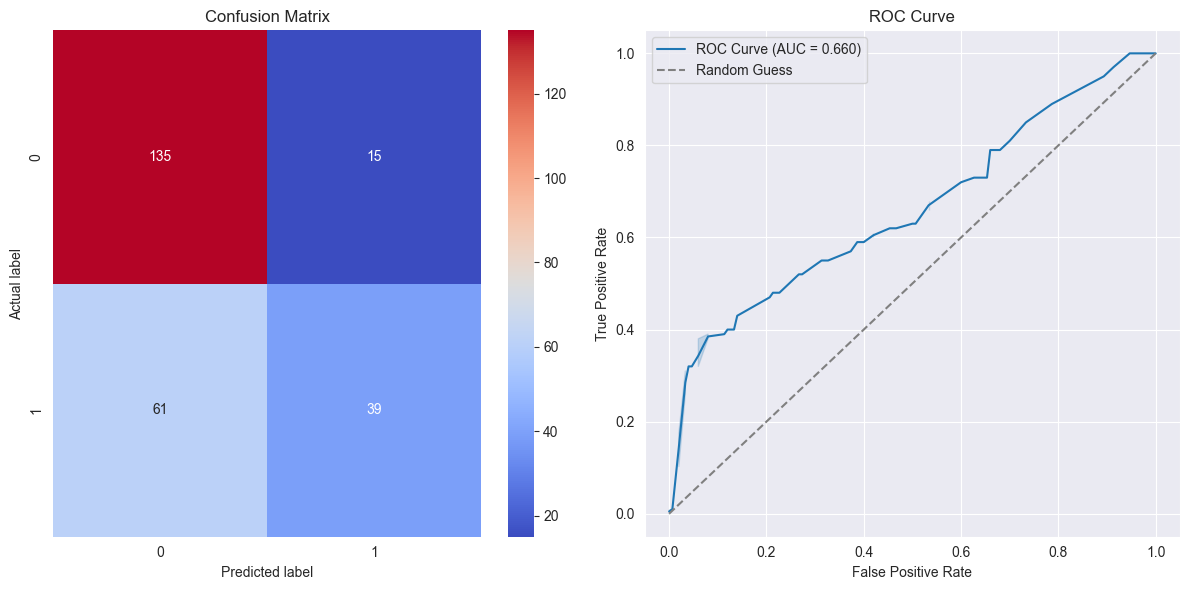

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 5-Fold Cross-Validation
cv_scores = cross_val_score(
    model,
    X_train,
    y_train.values.ravel(),
    scoring='f1',
    cv=5
)

print(model)
print("Cross-Validation F1 scores:", cv_scores)
print("Average CV F1:", cv_scores.mean())

# Performance Metrics
results_model = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob)
}

print("\nModel Performance Summary:")
for k, v in results_model.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("Actual label")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

sns.lineplot(x=fpr, y=tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", ax=ax[1])
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='grey',label='Random Guess', ax=ax[1])

ax[1].set_title("ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

plt.tight_layout()
plt.show()


### Initial Results

Let's talk through what all this means for our baseline model. For context we know in our test data we have 40% of customers with TravelInsurance.

The cross validation shows us how well the model does on unseen data and helps us see how consistent our model is. We can see across the 5 folds it doesn't deviate to far away from 0.5 which shows some decent consistency.

- Accuracy - 0.692 : Out of all predictions how many did we get right? This is performed better than randomly guessing but we need other metrics to further validate.
- Precision - 0.7091: Out of all predicted positives (TravelInsurance = 1), how many were actually positive? This also performed better than randomly guessing.
- Recall - 0.39: Of all actual positives, how many did the model catch? In this case, the model really didn't do that great. We captured less than half of all actual positives.
-  F1 Score - 0.5032: This is a balance between Precision & Recall as it captures the quality of capturing TP and how many real TPs we caught. This tells us that the model is better than random but not very strong. This will largely be due to our low Recall score.
- ROC AUC - 0.660: Shows how well the model can tell apart the 2 classes overall. Ideally we want the chart to be as high into the left hand corner as possible. Here we see it's strugguling, anything close to the line suggests it's as reliable as random, this shows it's slightly better.





In [29]:
print(y_test['TravelInsurance'].value_counts()/len(y_test))

print(y_test['TravelInsurance'].value_counts())

TravelInsurance
0    0.6
1    0.4
Name: count, dtype: float64
TravelInsurance
0    150
1    100
Name: count, dtype: int64


### Can we find a better model?


In [30]:
model_params = {
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3,5,7]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1,5,10],
        }
    },
    'svm': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
    },
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(-12, -6, 7)
        },
    },
}


In [31]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, scoring='f1')
    clf.fit(X, y)
    scores.append({
        'model_name': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
    })

print(pd.DataFrame(scores).sort_values(by='best_score', ascending=False))

            model_name  best_score                best_params
3          naive_bayes    0.505133   {'var_smoothing': 1e-12}
0                  knn    0.502534         {'n_neighbors': 5}
1  logistic_regression    0.494043                   {'C': 1}
2                  svm    0.485524  {'C': 1, 'kernel': 'rbf'}


We're not seeing much difference at all compared to our baseline logistic regression model which suggests that we're more likely to get better results by adding more data to the model rather than hyperparameter-ising (I made up this word).

Let's go ahead and fit the Naive Bayes model to our test data and see how it performs.

In [32]:
model = GaussianNB(var_smoothing=1e-12)

# fit the model with data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Cross-Validation F1 scores: [0.51612903 0.51239669 0.53225806 0.53435115 0.42016807]
Average CV F1: 0.5030606006508257

Model Performance Summary:
Accuracy: 0.6800
Precision: 0.6613
Recall: 0.4100
F1: 0.5062
ROC AUC: 0.6481


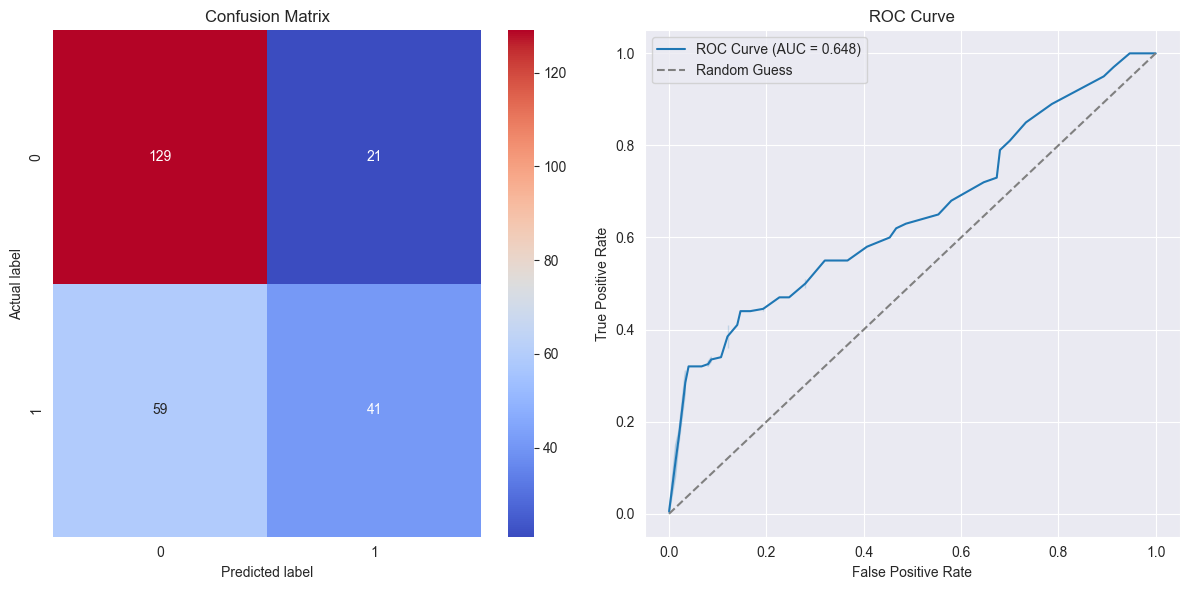

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 5-Fold Cross-Validation
cv_scores = cross_val_score(
    model,
    X_train,
    y_train.values.ravel(),
    scoring='f1',
    cv=5
)

print(model)
print("Cross-Validation F1 scores:", cv_scores)
print("Average CV F1:", cv_scores.mean())

# Performance Metrics
results_model = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob)
}

print("\nModel Performance Summary:")
for k, v in results_model.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("Actual label")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

sns.lineplot(x=fpr, y=tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", ax=ax[1])
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='grey',label='Random Guess', ax=ax[1])

ax[1].set_title("ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

plt.tight_layout()
plt.show()


# So? Bayes or Logistic?

Based on these results it's hard to tell which model is better as they both come with tradeoffs and the difference isn't sufficiently large to make a strong case for one or the other. The LogisticRegression (LR) on balance performs better but not by a high margin.

Going forward I would recommend we stick to the LR as it's less complex however there could an alternate scenario where the business favours catching a higher portion of True Positives (Recall) in which case we'd use the Naive Bayes model.

In short:
- General Use ➡️ LogisticRegression
- Specific need for higher Recall ➡️ Naive Bayes

Metrics | LogisticRegression | Naive Bayes |
|:--|:--|:--|
|**Accuracy** | ✅ Identifies more True cases| ❌ |
|**Precision** | ✅ Higher share of positive identfied were True Positives | ❌ |
|**Recall** | ❌ | ✅ Caught more True Positives from the dataset ✅|
|**F1** | ＝ On balance both models are indfferent| ＝ On balance both models are indfferent|
|**ROC AUC** | ✅ Marginally higher ROC AUC suggest better at distinguishing between the 2 classes| ❌ |


# What if we tried undersampling?

Cross-Validation F1 scores: [0.53623188 0.60150376 0.5890411  0.6119403  0.52238806]
Average CV F1: 0.5722210195111667

Model Performance Summary:
Accuracy: 0.6440
Precision: 0.5591
Recall: 0.5200
F1: 0.5389
ROC AUC: 0.6593


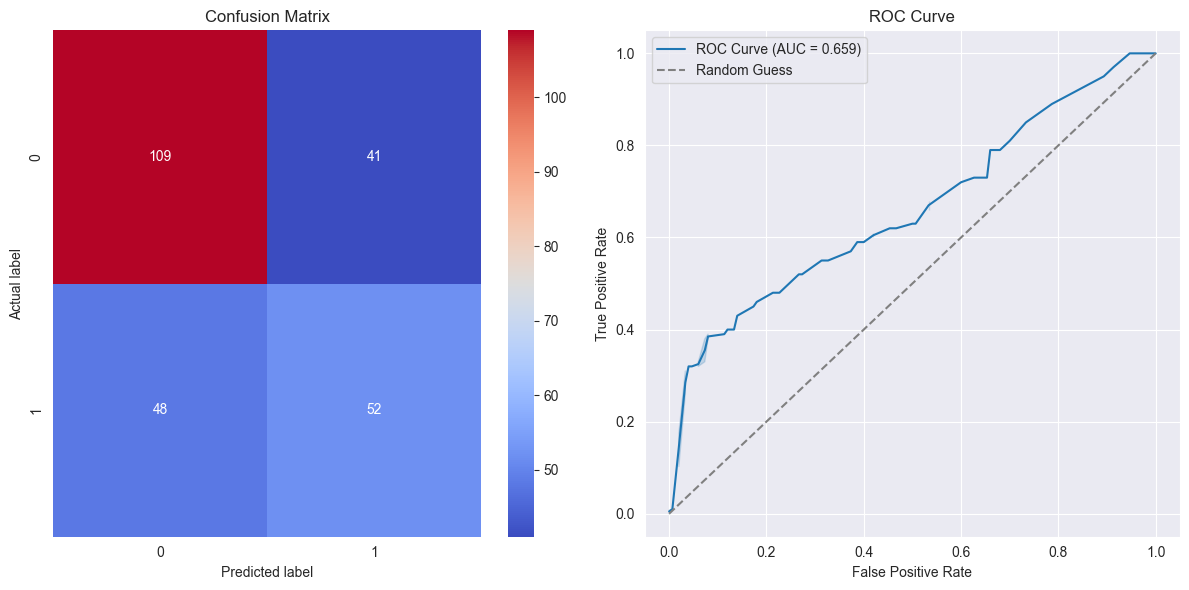

In [46]:
X = df_encoded[['EverTravelledAbroad_Yes','AnnualIncomeUSD','FrequentFlyer_Yes']]
y = df_encoded[['TravelInsurance']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


model = LogisticRegression(random_state=42)

# fit the model with data
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 5-Fold Cross-Validation
cv_scores = cross_val_score(
    model,
    X_train_resampled,
    y_train_resampled.values.ravel(),
    scoring='f1',
    cv=5
)

print("Cross-Validation F1 scores:", cv_scores)
print("Average CV F1:", cv_scores.mean())

# Performance Metrics
results_model = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob)
}

print("\nModel Performance Summary:")
for k, v in results_model.items():
    print(f"{k}: {v:.4f}")

# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("Actual label")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

sns.lineplot(x=fpr, y=tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", ax=ax[1])
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='grey',label='Random Guess', ax=ax[1])

ax[1].set_title("ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

plt.tight_layout()
plt.show()


In [44]:
model_params = {
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 5, 10],
        }
    },
    'svm': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
    },
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(-12, -6, 7)
        },
    },
}

scores = []

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, scoring='f1')
    clf.fit(X_resampled, y_resampled)
    scores.append({
        'model_name': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
    })

print(pd.DataFrame(scores).sort_values(by='best_score', ascending=False))

            model_name  best_score                     best_params
1  logistic_regression    0.581294                        {'C': 1}
3          naive_bayes    0.534703        {'var_smoothing': 1e-12}
2                  svm    0.512437  {'C': 0.1, 'kernel': 'linear'}
0                  knn    0.496952              {'n_neighbors': 7}


# 💡 LR is better suited with Undersampled data

Revisiting all the previous models with undersampled data we find that our outcomes change. LogisticRegression with a Regularization penalty of C = 1 has the highest performing F1 score across the GridSearch.

Coincidentally C=1 happens to be default value for regularisation so we don't need to re-run another LR model as our baseline undersampled LR model is already the best suited model for the job.

### Model Improvements

Metrics | LR No Undersampling | Naive Bayes No Undersampling | LR After Undersampling|
|:--|:--------------------|:-------------|:----------------------|
|**Accuracy** | ⬆️ 0.6960           | 0.6800       | 0.6440                |
|**Precision** | ⬆ 0.7222            | ️  0.6613    | 0.5591                |
|**Recall** | 0.3900              | 0.4100       | ⬆️ 0.5200             |
|**F1** | 0.5065              | 0.5062       | ⬆️ 0.5389             |
|**ROC AUC** | 0.659               | 0.6481       | ⬆️ 0.6593               |

With these new results we can recommend using an undersampled Logistic Regression to help identify customers likely to buy Travel Insurance. We do so because We see bigger improvements in correctly identifying True Positives and on balance does a better job at predicting between the 2 classes, even better than Naive Bayes.


# 🧾 Conclusion

After comparing Logistic Regression and Naive Bayes, we found that both models originally performed at a very similar level. If the goal is to have a strong, general-purpose classifier, Logistic Regression is the better option. Naive Bayes showed slightly higher recall without undersampling, but at the cost of precision, making it less ideal overall.

We also experimented with hyperparameter tuning, but it didn’t meaningfully improve results — indicating that the dataset itself, rather than model complexity, is the main limiting factor.

However, introducing undersampling noticeably changed the picture.

## 💡 Logistic Regression Performs Best With Undersampled Data
When revisiting all previous models using an undersampled dataset, the outcomes shifted significantly as using an undersampled Logistic Regression model for predicting customers likely to buy travel insurance performs best. It shows the largest gains in recall and F1, meaning it does a better job at correctly identifying true positive buyers and balancing both classes. In fact, it now outperforms Naive Bayes across key metrics.


## 📈 Recommendations

- Expand the dataset with more relevant and granular customer features.
- Hold off on deploying this model into production until the dataset is enriched — undersampling improves outcomes, but the underlying data is still too limited to support robust real-world performance.

## 🎯 Business Learning

Even though the predictive performance isn’t production-ready, we did uncover some useful customer insights:

- Customers with higher income were more likely to buy travel insurance.
- Customers who have travelled abroad before also showed a higher likelihood of purchasing.

These insights can already be used to support targeted demographic marketing while we continue improving the modelling side.
